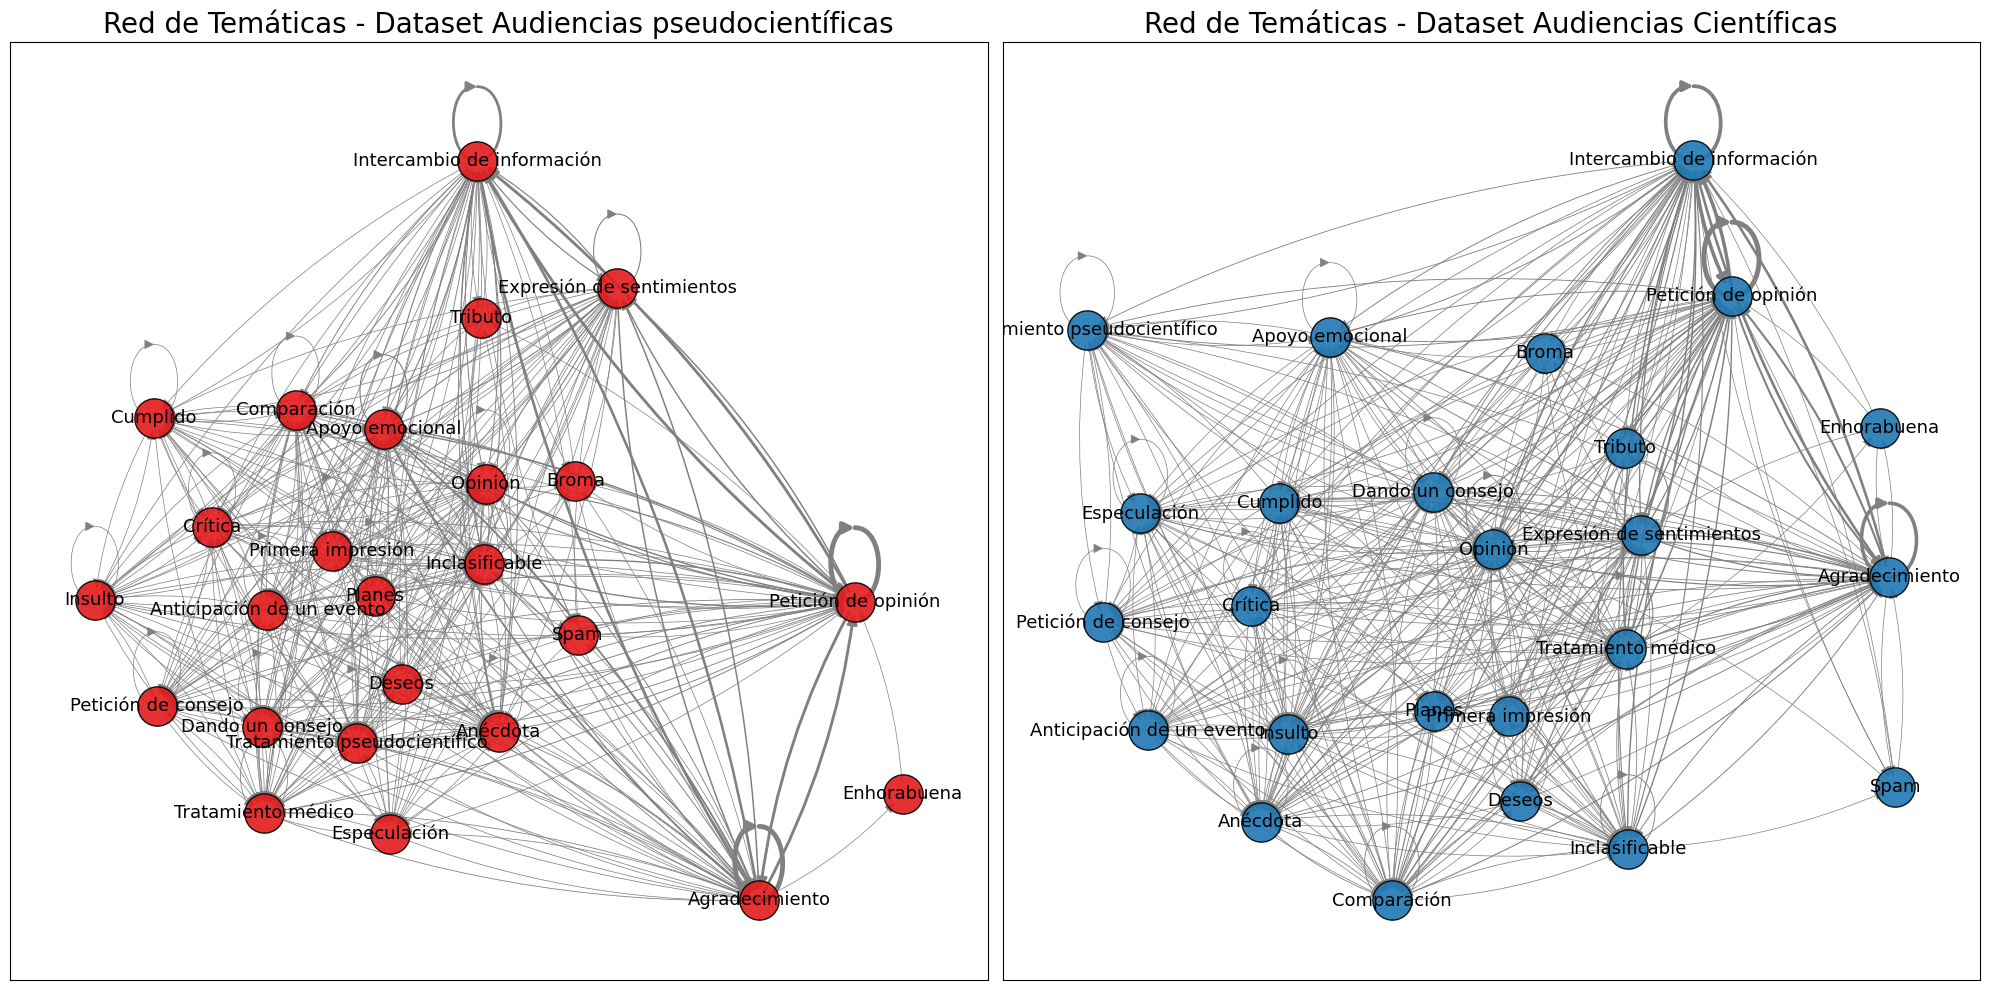

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Cargar ambos datasets
df_pseudo = pd.concat([
    pd.read_csv("Evaluated final datasets/Evaluated_pseudo_1.csv"),
    pd.read_csv("Evaluated final datasets/Evaluated_pseudo_2.csv")
], ignore_index=True)
df_pseudo['timestamp'] = pd.to_datetime(df_pseudo['timestamp'])
df_pseudo = df_pseudo.rename(columns={df_pseudo.columns[-1]: 'Tematica del comentario'})

df_scientific = pd.read_csv("Evaluated final datasets/Evaluated_scientific.csv").iloc[:, 1:]
df_scientific['timestamp'] = pd.to_datetime(df_scientific['timestamp'])

# Función para crear la red
def create_network(df):
    df['next_tematica'] = df['Tematica del comentario'].shift(-1)
    G = nx.DiGraph()
    
    for conversation_id, group_df in df.groupby("conversation_id"):
        for index, row in group_df.iterrows():
            source = row['Tematica del comentario']
            target = row['next_tematica']
            
            if pd.notna(source) and pd.notna(target):
                if G.has_edge(source, target):
                    G[source][target]['weight'] += 1
                else:
                    G.add_edge(source, target, weight=1)
    return G

# Crear las redes
G_pseudo = create_network(df_pseudo)
G_scientific = create_network(df_scientific)

# Configuración de la figura
plt.figure(figsize=(20, 10))

# Función para normalizar pesos
def normalize_weights(weights, max_width=3, base_width=0.5):
    max_weight = max(weights) if weights else 1
    return [base_width + (w/max_weight)*max_width for w in weights]

# Subplot 1: Red pseudo
plt.subplot(1, 2, 1)
pos1 = nx.kamada_kawai_layout(G_pseudo)
edge_weights_pseudo = [d['weight'] for _, _, d in G_pseudo.edges(data=True)]

nx.draw_networkx_nodes(G_pseudo, pos1,
                      node_size=800,
                      node_color='#e31a1c',  # Rojo
                      edgecolors='black',
                      alpha=0.9)

nx.draw_networkx_edges(G_pseudo, pos1,
                      edge_color='gray',  # Azul claro
                      arrows=True,
                      arrowsize=15,
                      width=normalize_weights(edge_weights_pseudo),
                      connectionstyle='arc3,rad=0.1')

nx.draw_networkx_labels(G_pseudo, pos1, font_size=13, font_color='black')
plt.title("Red de Temáticas - Dataset Audiencias pseudocientíficas", fontsize=20)

# Subplot 2: Red científica
plt.subplot(1, 2, 2)
pos2 = nx.kamada_kawai_layout(G_scientific)
edge_weights_scientific = [d['weight'] for _, _, d in G_scientific.edges(data=True)]

nx.draw_networkx_nodes(G_scientific, pos2,
                      node_size=800,
                      node_color='#1f78b4',  # Azul
                      edgecolors='black',
                      alpha=0.9)

nx.draw_networkx_edges(G_scientific, pos2,
                      edge_color='gray',  # Rosa claro
                      arrows=True,
                      arrowsize=15,
                      width=normalize_weights(edge_weights_scientific),
                      connectionstyle='arc3,rad=0.1')

nx.draw_networkx_labels(G_scientific, pos2, font_size=13, font_color='black')
plt.title("Red de Temáticas - Dataset Audiencias Científicas", fontsize=20)

# Ajustar y guardar
plt.tight_layout()
plt.savefig("redes_originales.png", dpi=300, bbox_inches='tight')
plt.show()

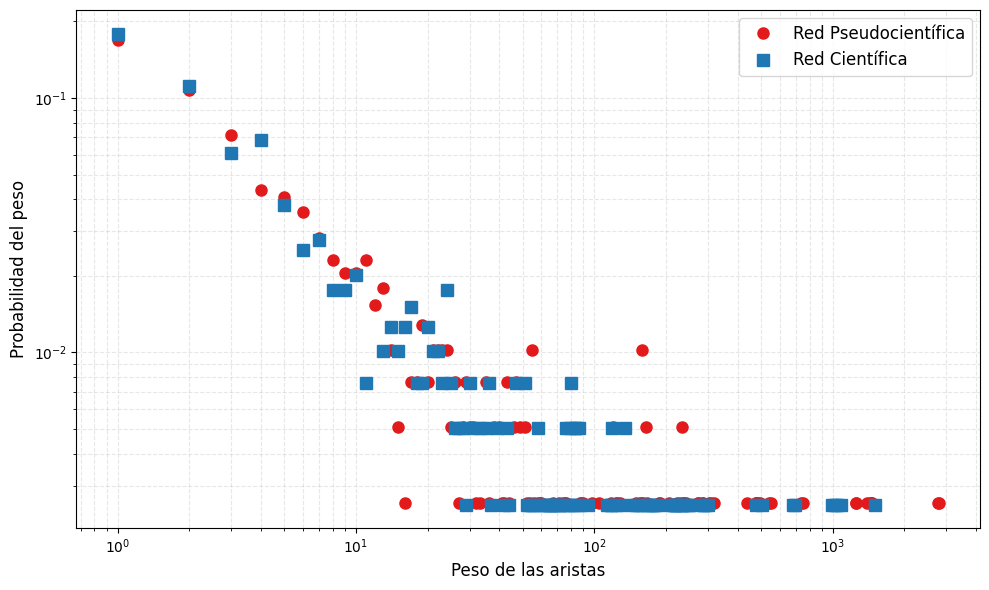

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Función para calcular las probabilidades de los pesos
def calculate_weight_probabilities(G):
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    weight_count = Counter(edge_weights)
    total_links = len(G.edges)
    return {k: v / total_links for k, v in weight_count.items()}

# Calculamos las probabilidades para ambas redes
prob_pseudo = calculate_weight_probabilities(G_pseudo)
prob_scientific = calculate_weight_probabilities(G_scientific)

# Extraemos los datos para graficar
weights_pseudo = list(prob_pseudo.keys())
probs_pseudo = list(prob_pseudo.values())

weights_sci = list(prob_scientific.keys())
probs_sci = list(prob_scientific.values())

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Graficamos ambas redes
plt.loglog(weights_pseudo, probs_pseudo, 
           color='#e31a1c',  # Azul (coherente con la red pseudo)
           markersize=8, 
           marker='o', 
           linestyle='',
           label='Red Pseudocientífica')

plt.loglog(weights_sci, probs_sci, 
           color='#1f78b4',  # Rojo (coherente con la red científica)
           markersize=8, 
           marker='s',  # Cuadrados para diferenciar
           linestyle='',
           label='Red Científica')

# Añadimos elementos descriptivos
plt.xlabel("Peso de las aristas", fontsize=12)
plt.ylabel("Probabilidad del peso", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Ajustamos los márgenes
plt.tight_layout()
plt.savefig("probabilidades_pesos.png", dpi=300, bbox_inches='tight')
# Mostramos el gráfico
plt.show()

In [13]:
import pandas as pd

# Función para obtener los top 10 nodos por grado
def get_top_degree_nodes(G, network_name):
    degrees = dict(G.degree())
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 nodos por grado - {network_name}:")
    print("-" * 40)
    print(f"{'Nodo':<20} {'Grado':<10}")
    print("-" * 40)
    for node, degree in top_nodes:
        print(f"{str(node):<20} {degree:<10}")
    print("-" * 40)
    
    return pd.DataFrame(top_nodes, columns=['Nodo', 'Grado'])

# Obtener y mostrar los resultados para ambas redes
df_top_pseudo = get_top_degree_nodes(G_pseudo, "Red Pseudo")
df_top_scientific = get_top_degree_nodes(G_scientific, "Red Científica")

# Si quieres guardar los resultados en DataFrames para uso posterior
# df_top_pseudo y df_top_scientific ya contienen la información


Top 10 nodos por grado - Red Pseudo:
----------------------------------------
Nodo                 Grado     
----------------------------------------
Petición de opinión  48        
Intercambio de información 48        
Agradecimiento       47        
Expresión de sentimientos 44        
Apoyo emocional      44        
Anécdota             43        
Inclasificable       42        
Opinión              42        
Comparación          41        
Tratamiento médico   38        
----------------------------------------

Top 10 nodos por grado - Red Científica:
----------------------------------------
Nodo                 Grado     
----------------------------------------
Intercambio de información 49        
Agradecimiento       49        
Petición de opinión  49        
Opinión              46        
Expresión de sentimientos 45        
Tratamiento médico   43        
Comparación          42        
Inclasificable       40        
Insulto              39        
Anécdota             

In [14]:
import pandas as pd
import networkx as nx

# Función para calcular y mostrar los top 10 nodos por betweenness centrality
def get_top_betweenness_nodes(G, network_name):
    # Calcular betweenness centrality
    betweenness = nx.betweenness_centrality(G)
    
    # Ordenar y seleccionar top 10
    top_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 nodos por Betweenness Centrality - {network_name}:")
    print("-" * 60)
    print(f"{'Nodo':<30} {'Betweenness Centrality':<25}")
    print("-" * 60)
    for node, bc in top_nodes:
        print(f"{str(node):<30} {bc:.6f}")
    print("-" * 60)
    
    return pd.DataFrame(top_nodes, columns=['Nodo', 'Betweenness Centrality'])

# Calcular y mostrar para ambas redes
df_betweenness_pseudo = get_top_betweenness_nodes(G_pseudo, "Red Pseudo")
df_betweenness_scientific = get_top_betweenness_nodes(G_scientific, "Red Científica")

# Combinación de los resultados en un solo DataFrame para comparación
combined_betweenness = pd.concat([
    df_betweenness_pseudo.assign(Red='Pseudo'),
    df_betweenness_scientific.assign(Red='Científica')
], ignore_index=True)

# Mostrar tabla combinada 
print("\nComparación entre ambas redes:")
print(combined_betweenness.pivot(index='Nodo', columns='Red', values='Betweenness Centrality'))


Top 10 nodos por Betweenness Centrality - Red Pseudo:
------------------------------------------------------------
Nodo                           Betweenness Centrality   
------------------------------------------------------------
Petición de opinión            0.089329
Agradecimiento                 0.080271
Intercambio de información     0.056358
Expresión de sentimientos      0.033338
Anécdota                       0.029604
Apoyo emocional                0.028253
Inclasificable                 0.025665
Opinión                        0.019377
Comparación                    0.016335
Tratamiento pseudocientífico   0.009271
------------------------------------------------------------

Top 10 nodos por Betweenness Centrality - Red Científica:
------------------------------------------------------------
Nodo                           Betweenness Centrality   
------------------------------------------------------------
Agradecimiento                 0.077644
Intercambio de información 

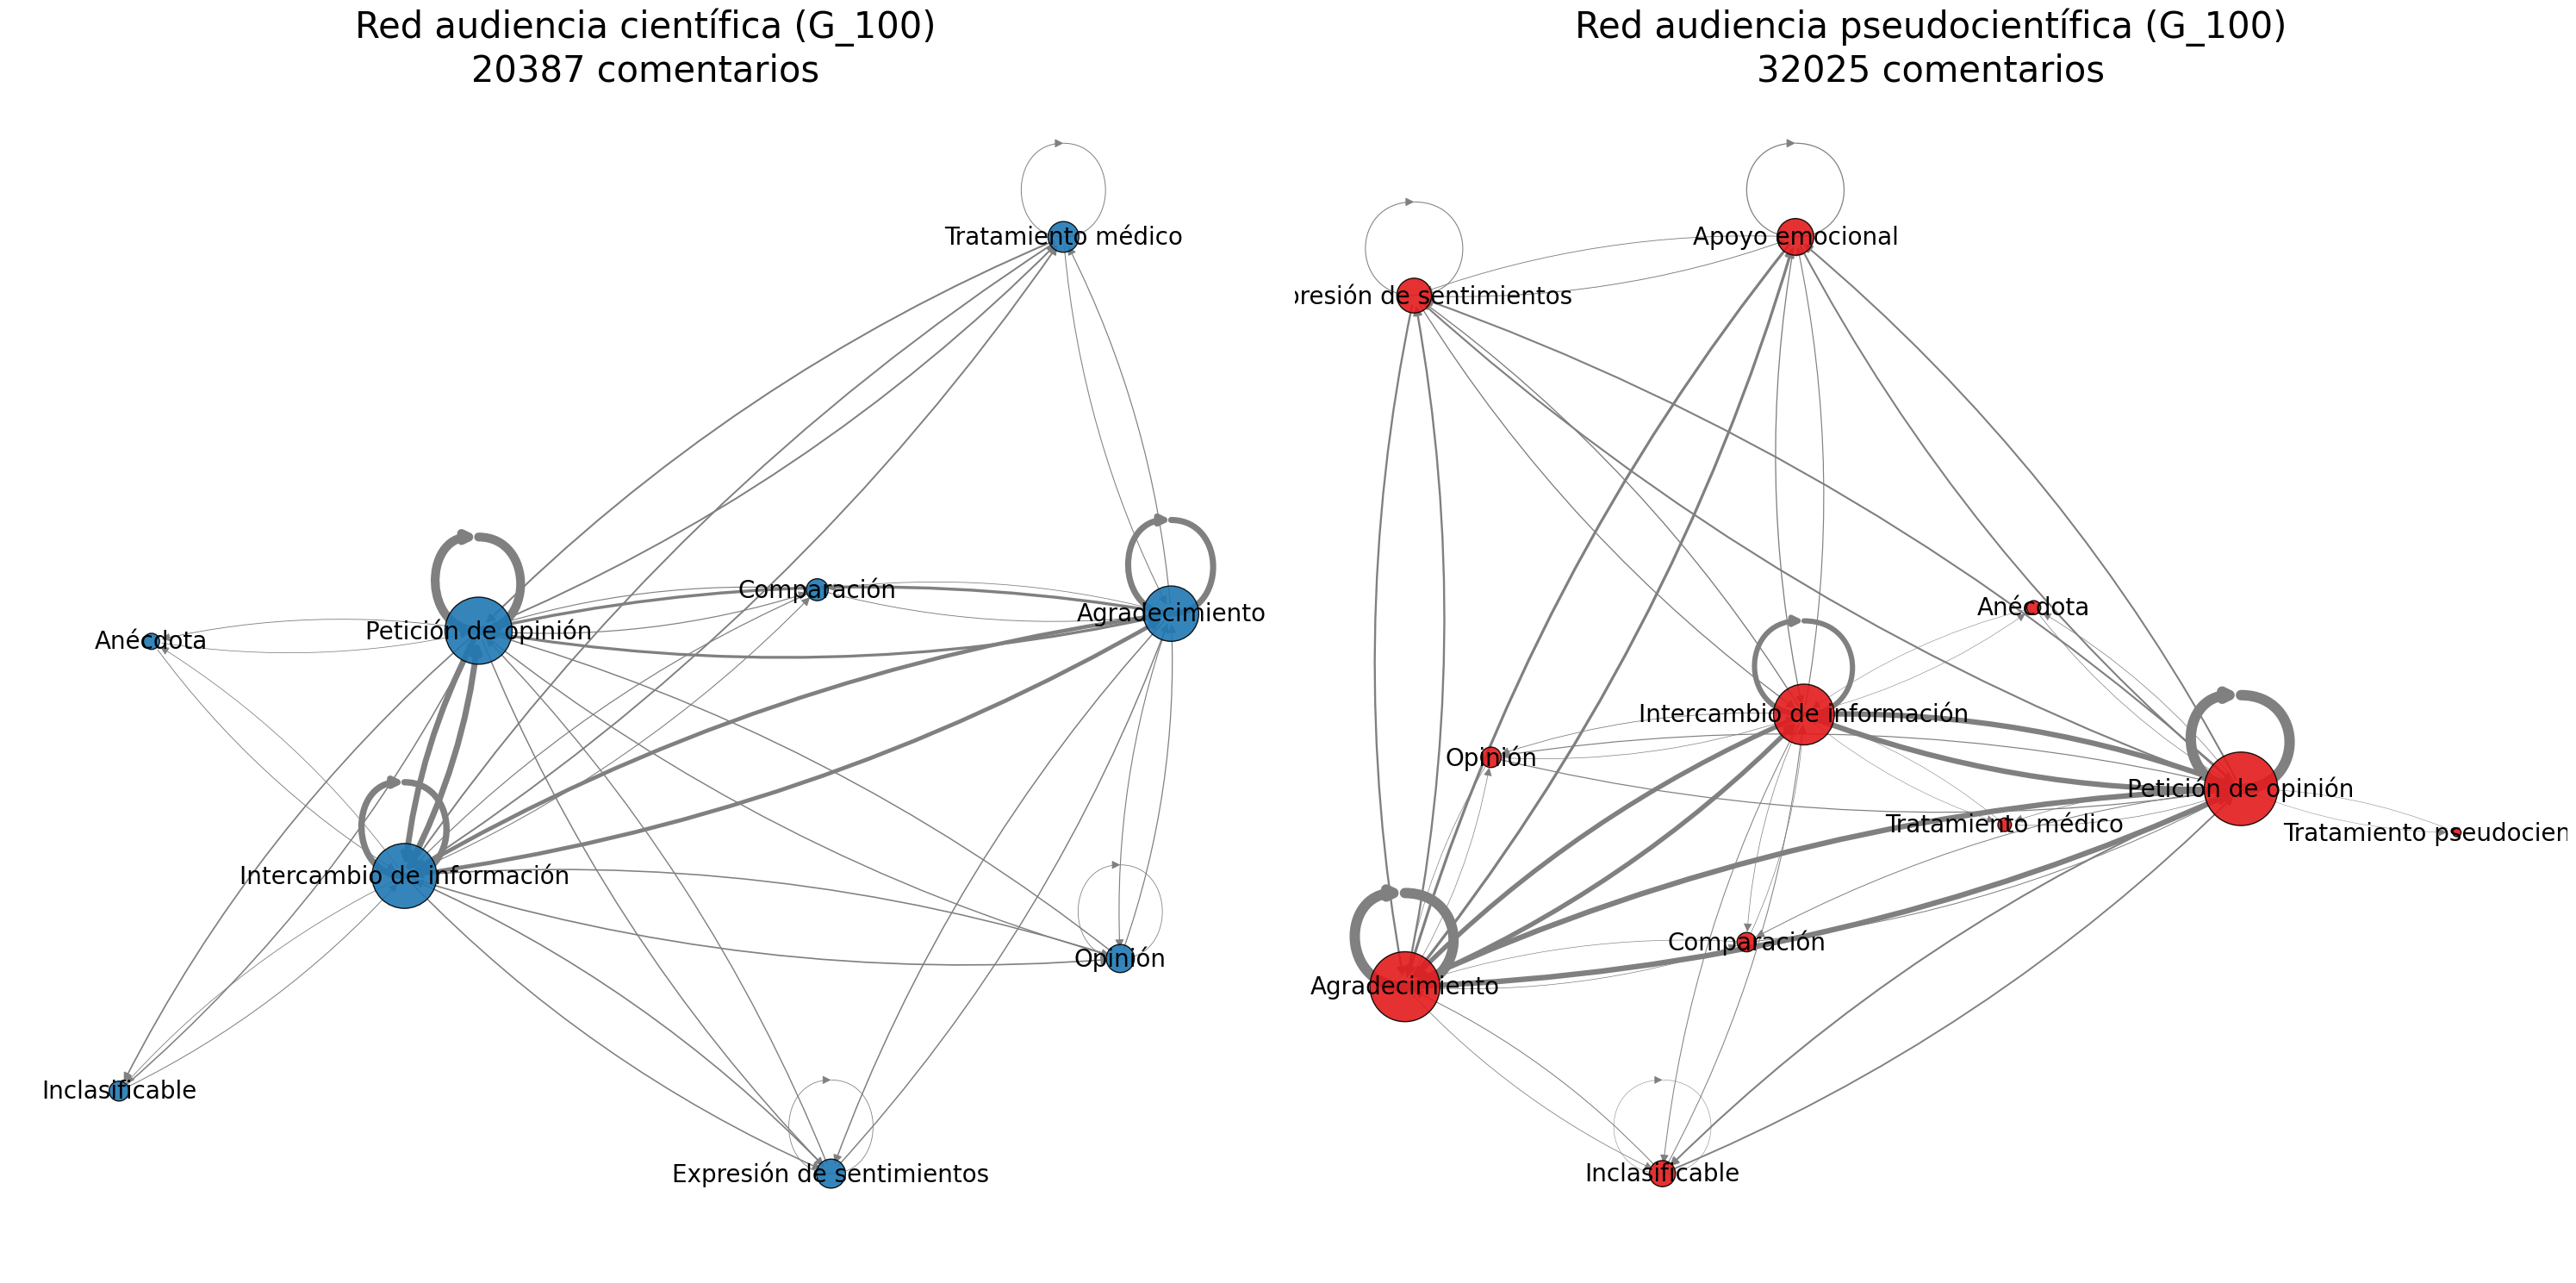

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

def apply_weight_threshold(G, threshold):
    G_filtered = G.__class__()  # Preserva si es Graph, DiGraph, etc.
    for u, v, data in G.edges(data=True):
        if data['weight'] >= threshold:
            G_filtered.add_edge(u, v, weight=data['weight'])
    return G_filtered


def plot_filtered_network(G, total_comments, ax, title, color_scheme):
    """Función para visualizar una red filtrada con umbral de peso"""
    # Calcular grados de entrada ponderados normalizados
    weighted_in_degrees = {k: v / total_comments for k, v in dict(G.in_degree(weight='weight')).items()}
    
    # Layout
    pos = nx.kamada_kawai_layout(G)
    
    # Dibujar nodos (tamaño proporcional al grado de entrada normalizado)
    nx.draw_networkx_nodes(G, pos,
                         node_size=[v * 15000 for v in weighted_in_degrees.values()],
                         node_color=color_scheme['node'],
                         edgecolors='black',
                         alpha=0.9,
                         ax=ax)
    
    # Dibujar aristas (ancho proporcional al peso normalizado)
    nx.draw_networkx_edges(G, pos,
                         edge_color=color_scheme['edge'],
                         arrows=True,
                         arrowsize=15,
                         width=[d['weight'] / total_comments * 100 for _, _, d in G.edges(data=True)],
                         connectionstyle='arc3,rad=0.1',
                         ax=ax)
    
    # Etiquetas solo de los nodos más relevantes
    top_nodes = sorted(weighted_in_degrees.items(), key=lambda x: x[1], reverse=True)[:15]  # Top 15 nodos
    labels = {node: node for node, _ in top_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=20, ax=ax)
    
    ax.set_title(title, fontsize=30)
    ax.axis('off')

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Definir esquemas de color para cada red
color_pseudo = {'node': '#e31a1c', 'edge': 'gray'}  # Azul/azul claro
color_sci = {'node': '#1f78b4', 'edge': 'gray'}    # Rojo/rosa claro

# Aplicar umbral de peso 100 a ambas redes
G_pseudo_100 = apply_weight_threshold(G_pseudo, 100)
G_sci_100 = apply_weight_threshold(G_scientific, 100)

# Visualizar redes
plot_filtered_network(G_sci_100, 20387, ax1, 
                    "Red audiencia científica (G_100)\n20387 comentarios", color_sci)
plot_filtered_network(G_pseudo_100, 32025, ax2, 
                    "Red audiencia pseudocientífica (G_100)\n32025 comentarios", color_pseudo)

plt.tight_layout()
plt.savefig("redes_G100_comparadas.png", dpi=300, bbox_inches='tight')
plt.show()